<a id="introduction"></a>
**Harvard University**<br/>
**Fall 2024**<br/>
**Team Name**: Kirk boys <br/>
**Collaborators**: Michael Moorman, Dylan Park, Luke Richey<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb

## Background and Motivation

Cardiovascular diseases remain the leading cause of death globally, with significant variations in prevalence based on geographic location. We want to understand the correlation between various health factors and cardiovascular deaths in hopes that this could lead to insights into public health. 

We take the data from the World Health Organization (WHO).

<a id="1"></a>

## Problem Statement

[Return to contents](#contents)

How do obesity prevalence, smoking rate, alcohol consumption, and healthcare expenditure correlate with cardiovascular mortality rates? What is the most important to alleviate?


In [23]:
# RUN THIS CELL
# Import libraries and set pandas visuals
import itertools
import math
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
# mean absolute error
from sklearn.metrics import mean_absolute_error

from matplotlib.lines import Line2D

# our own helpers
import helpers

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

<a id="contents"></a>

# Exploratory Data Analysis on Cardiovascular Mortality and Obesity Prevalence

## Table of Contents
1. [Introduction](#introduction)
2. [Problem Statement](#1)
3. [Overview and Data Description](#2)
4. [Summary of the Data](#3)
4. [Deeper Understanding of the Data](#4)
5. [Meaningful Insights](#5)
6. [Clean and Labeled Visualizations](#6)
7. [Data Description](#7)
8. [Noteworthy Findings](#8)
9. [Baseline Model or Implementation Plan](#9)

---




Here we work to merge different datasets and create a single merged dataset that combines the different health factors together to determine how different health factors affect cardiovascular death rates among different countries.

In [24]:
tobacco = pd.read_csv('data/Tobacco Use Estimates.csv')
#Doesn't have 2014 data
tobacco = tobacco[tobacco['Period'] == 2015]
tobacco = tobacco[tobacco['IndicatorCode'] == 'M_Est_tob_curr_std']
tobacco['Dim1'] = tobacco['Dim1'].replace("Both sexes", "All")
tobacco = tobacco.drop(columns=['Unnamed: 0','IndicatorCode','Indicator', 'Period', 'ValueType','Location type','Period type','IsLatestYear','Dim1 type','Dim1ValueCode','Value','Language','DateModified', 'ParentLocationCode', 'ParentLocation'])
tobacco = tobacco.rename(columns={'Dim1': 'Sex', 'SpatialDimValueCode': 'Country Code', 'FactValueNumeric': 'TobaccoUse(%)','FactValueNumericLow': 'TobaccoUseLow(%)','FactValueNumericHigh': 'TobaccoUseHigh(%)'})
tobacco.to_csv('data/cleaned_tobacco_data.csv', index=False)

In [25]:
alcohol = pd.read_csv('data/alcohol_consumption_data.csv')
alcohol = alcohol[alcohol['Period'] == 2014]
alcohol['Dim1'] = alcohol['Dim1'].replace("Both sexes", "All")
alcohol = alcohol.drop(columns=['Unnamed: 0.1','Unnamed: 0','index','IndicatorCode','Indicator','Period','Dim1ValueCode','ValueType','Location type','Period type','IsLatestYear','Dim1 type','Value', 'ParentLocationCode', 'ParentLocation'])
alcohol = alcohol.rename(columns={'SpatialDimValueCode': 'Country Code', 'Dim1':'Sex','FactValueNumeric': 'LtrsPureAlcConsumedAvg','FactValueNumericLow': 'LtrsPureAlcConsumedLow','FactValueNumericHigh':'LtrsPureAlcConsumedAvgHigh'})
alcohol.to_csv('data/cleaned_alcohol_data.csv', index=False)

In [26]:
healthcare_expenditure = pd.read_csv('data/Current Health Expenditure per Capita.csv')
healthcare_expenditure = healthcare_expenditure[healthcare_expenditure['Period'] == 2014]
healthcare_expenditure = healthcare_expenditure.drop(columns=['IndicatorCode','Indicator','Period','ValueType','Location type','Period type','IsLatestYear','FactValueNumeric','Language','DateModified', 'ParentLocationCode', 'ParentLocation'])
healthcare_expenditure = healthcare_expenditure.rename(columns={'Value': 'HealthExpenditurePerCapita(USD)', 'SpatialDimValueCode': 'Country Code'})

In [15]:
# Pulling data from csv
obesity = pd.read_csv('data/Obesity Prevalence.csv')
mortality = pd.read_csv('data/Mortality-Database-Cardiovascular-Diseases-Oct-29-2024.csv')

obesity = obesity.drop(['Language', 'DateModified', 'FactComments', 'FactValueTranslationID', 'Dim3 type', 'Dim3', 'Dim3ValueCode', 'DataSourceDimValueCode', 'DataSource','FactValueNumericPrefix', 'FactValueUoM', 'FactValueNumericLowPrefix', 'FactValueNumericHighPrefix'],axis=1)
mortality = mortality.drop(columns=["Age-standardized death rate per 100 000 standard population", 'Region Code', 'Region Name', 'Country Name', 'Age group code', 'Number'])
mortality = mortality.dropna()

obesity = obesity[obesity['Period'] == 2014]
obesity['Sex'] = obesity['Dim1'].replace("Both sexes", "All")
# all already 18+
obesity = obesity.drop(columns=['Value','Indicator','Location type',"Period", 'IndicatorCode', 'IsLatestYear', 'Period type', 'Dim1', 'Dim1 type', 'Dim1ValueCode', 'Dim2 type','Dim2','Dim2ValueCode'])
obesity = obesity.rename(columns={'FactValueNumeric':'ObesityPrevalence(%)','FactValueNumericLow':'ObesityPrevalenceLow(%)','FactValueNumericHigh':'ObesityPrevalenceHigh(%)','SpatialDimValueCode':'Country Code'})
obesity.to_csv("data/2014_obesity_data.csv", index=False)

mortality = mortality[mortality['Year'] == 2014]
mortality = mortality[mortality['Age Group'] == "[All]"]
mortality.to_csv("data/2014_mortality_data.csv", index=False)

merged_dataset = pd.merge(obesity, mortality, left_on=["Country Code", "Sex"], right_on=['Country Code', 'Sex'], how='inner')
merged_dataset = merged_dataset.drop(columns=["ValueType"])
merged_dataset.to_csv("data/merged_data.csv", index=False)

new_merged_dataset = pd.merge(tobacco, merged_dataset, left_on=["Country Code", 'Location', "Sex"], right_on=['Country Code', 'Location', 'Sex'], how='inner')
new_merged_dataset = new_merged_dataset.drop(columns=["Age Group"])
new_merged_dataset.to_csv("data/merged_datav2.csv", index=False)

merged_dataset_v3 = pd.merge(alcohol, new_merged_dataset, left_on=["Country Code", 'Location', "Sex"], right_on=['Country Code', 'Location', 'Sex'], how='inner')
merged_dataset_v3.to_csv("data/merged_datav3.csv", index=False)

fullDf = pd.merge(healthcare_expenditure, merged_dataset_v3, left_on=["Country Code", 'Location'], right_on=['Country Code', 'Location'], how='inner')
fullDf = fullDf.drop(columns=['Unnamed: 0'])
fullDf.to_csv("data/Fully_Merged_data.csv", index=False)

In [16]:
fullDf.head()

,Country Code,Location,HealthExpenditurePerCapita(USD),Sex,LtrsPureAlcConsumedAvg,LtrsPureAlcConsumedLow,LtrsPureAlcConsumedAvgHigh,TobaccoUse(%),TobaccoUseLow(%),TobaccoUseHigh(%),ParentLocationCode,ParentLocation,ObesityPrevalence(%),ObesityPrevalenceLow(%),ObesityPrevalenceHigh(%),Year,Percentage of cause-specific deaths out of total deaths,Death rate per 100 000 population
0,HUN,Hungary,1006.16,All,10.52,7.08,13.83,33.8,26.6,40.9,EUR,Europe,26.39,24.74,28.05,2014,49.709,636.357
1,HUN,Hungary,1006.16,Male,17.13,11.53,22.71,38.4,30.6,46.3,EUR,Europe,27.88,25.43,30.43,2014,44.590,588.180
2,HUN,Hungary,1006.16,Female,4.65,3.10,6.24,29.1,22.7,35.5,EUR,Europe,24.56,22.38,26.77,2014,54.643,680.178
3,BRA,Brazil,1013.57,Male,13.35,9.01,18.00,18.7,15.2,22.2,AMR,Americas,17.22,16.00,18.48,2014,25.700,178.595
4,BRA,Brazil,1013.57,Female,3.58,2.39,4.88,11.1,8.8,13.5,AMR,Americas,23.97,22.72,25.25,2014,30.422,157.379


<a id="2"></a>

## Overview and data description

[Return to contents](#contents)

### Data

#### Obesity Prevalence Data

- **IndicatorCode**: a unique identifier for the overall data 
- **Indicator**: Description of overall data
- **ValueType**: data type
- **ParentLocationCode**: Region code (i.e. AFR)
- **ParentLocation**: Region name (i.e. Africa)
- **Location type**: Location type (i.e. country, territory)
- **SpatialDimValueCode**: Location code (i.e. ETH)
- **Location**: Location name (i.e. Ethiopia)
- **Period type**: Time period type (i.e. Year)
- **Period**: Specific time period
- **IsLatestYear**: Boolean for latest data
- **Dim1 type**: Sex
- **Dim1**: Gender
- **Dim1ValueCode**: Gender code
- **Dim2 type**: Age group
- **Dim2**: Specific age group
- **Dim2ValueCode**: Age code
- **FactValueNumeric**: Estimated obesity percentage
- **FactValueNumericLow**: Lower bound on obesity percentage
- **FactValueNumericHigh**: Upper bound on obesity percentage
- **Value**: Estimated obesity percentage [Lower bound - Upper bound] rounded to the nearest tenth

#### Mortality Data
- **Region Code**: Region ID
- **Region Name**: Region name
- **Country Code**: Country ID
- **Country Name**: Country Name
- **Year**: Year data was collected
- **Sex**: Sex of partipants
- **Age group code**: Age ID
- **Age Group**: Age in [lower-upper] format
- **Number**: Absolute number of deaths
- **Percentage of cause-specific deaths out of total deaths**: 
- **"Age-standardized death rate per 100 000 standard population"**:
- **"Death rate per 100 000 population"**:

The data for this project is derived from two main sources:

1. **Cardiovascular Mortality Dataset**:
   - Source: WHO dataset containing statistics on cardiovascular disease mortality across multiple countries and years.
   - Features: Includes metrics such as:
     - **Number**: Total deaths reported.
     - **Percentage of cause-specific deaths out of total deaths**: The proportion of deaths attributed to cardiovascular diseases.
     - **Death rate per 100 000 population**: Mortality rate standardized per 100,000 individuals.
     - Demographic attributes like **Country Name**, **Year**, **Sex**, and **Age Group**.
   - Preprocessing:
     - Rows with missing or `NaN` values in critical columns, such as **Death rate per 100 000 population**, were excluded.
     - Rows with `Age group code` as `Age_unknown` were removed.
     - The dataset was limited to countries in the **developed world**, as these countries exhibited more reliable and complete data for both mortality and obesity.

2. **Obesity Prevalence Dataset**:
   - Source: A global WHO dataset reporting estimated obesity prevalence percentages across different countries, age groups, and genders.
   - Features:
     - **FactValueNumeric**: The estimated percentage of obesity prevalence.
     - Demographic attributes like **Country Name**, **Gender (Dim1)**, and **Age Group (Dim2)**.
   - Preprocessing:
     - Country names were standardized to match those in the mortality dataset (e.g., "United States of America" was renamed to "United States").
     - The dataset was filtered to include only countries with complete data and overlap with the mortality dataset.

#### Initial Explorations:
- Early exploration of the datasets revealed high percentages of missing data, particularly for developing countries. These were excluded to ensure data reliability.
- Limiting the analysis to developed countries provided a more consistent and balanced view of obesity prevalence and cardiovascular mortality, with the included countries showing relatively even distributions of obesity prevalence (e.g., ranging from 3.3% in Japan to 24.8% in New Zealand).

#### Methods:
- **Data Cleaning**: Standardized country names, removed incomplete rows, and merged datasets on common attributes such as **Country Name** and **Year**.
- **Exploratory Data Analysis**: Generated histograms, boxplots, scatter plots, and correlation matrices to identify patterns and relationships.
- **Data Aggregation**: Grouped by country and demographic attributes to compute mean obesity prevalence and mortality rates for clearer analysis.


<a id="3"></a>

## Summary of the Data

[Return to contents](#contents)

Our analysis integrates two datasets:

1. **Cardiovascular Mortality Dataset**:
   - Contains 42,084 records and 12 features related to cardiovascular mortality statistics across multiple countries and years. Key features include:
     - **Number**: Total deaths reported.
     - **Percentage of cause-specific deaths out of total deaths**: The proportion of deaths attributed to cardiovascular diseases.
     - **Death rate per 100 000 population**: Mortality rate standardized per 100,000 individuals.
   - **Key Observations**:
     - Histograms reveal that **Death rate per 100 000 population** is right-skewed, indicating most values are concentrated at lower death rates.
     - Correlation analysis shows a strong positive relationship between **Number** and **Death rate per 100 000 population**.

2. **Obesity Dataset**:
   - Contains 891 records and 34 features related to obesity prevalence statistics across multiple countries and years. Key features include:
     - **FactValueNumeric**: The estimated percentage of obesity prevalence in a given population.
     - **Dim1**: Gender (Male, Female, or All).
     - **Dim2**: Age group (e.g., 18+, 20-24).
   - **Key Observations**:
     - Obesity prevalence is available for 8 overlapping countries in the mortality dataset: Norway, Germany, Canada, United Kingdom, Australia, Japan, New Zealand, United States, and France.
     - The dataset spans multiple age groups and genders, providing granularity for demographic-specific analysis.



In [17]:
# Cardiovascular mortality dataset summary
print(mortality.shape)
print(mortality.dtypes)
print(mortality.describe())


(300, 6)
Country Code                                                object
Year                                                         int64
Sex                                                         object
Age Group                                                   object
Percentage of cause-specific deaths out of total deaths    float64
Death rate per 100 000 population                          float64
dtype: object
         Year  Percentage of cause-specific deaths out of total deaths  \
count   300.0                                                  300.000   
mean   2014.0                                                   34.459   
std       0.0                                                   11.981   
min    2014.0                                                   13.346   
25%    2014.0                                                   26.260   
50%    2014.0                                                   31.296   
75%    2014.0                                            

## Deeper Understanding of the Data <a id="4"></a>

/var/folders/mz/9c964jh507d14dfs_dr4n2lw0000gn/T/ipykernel_66176/72784330.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # Adjust layout to prevent clipping


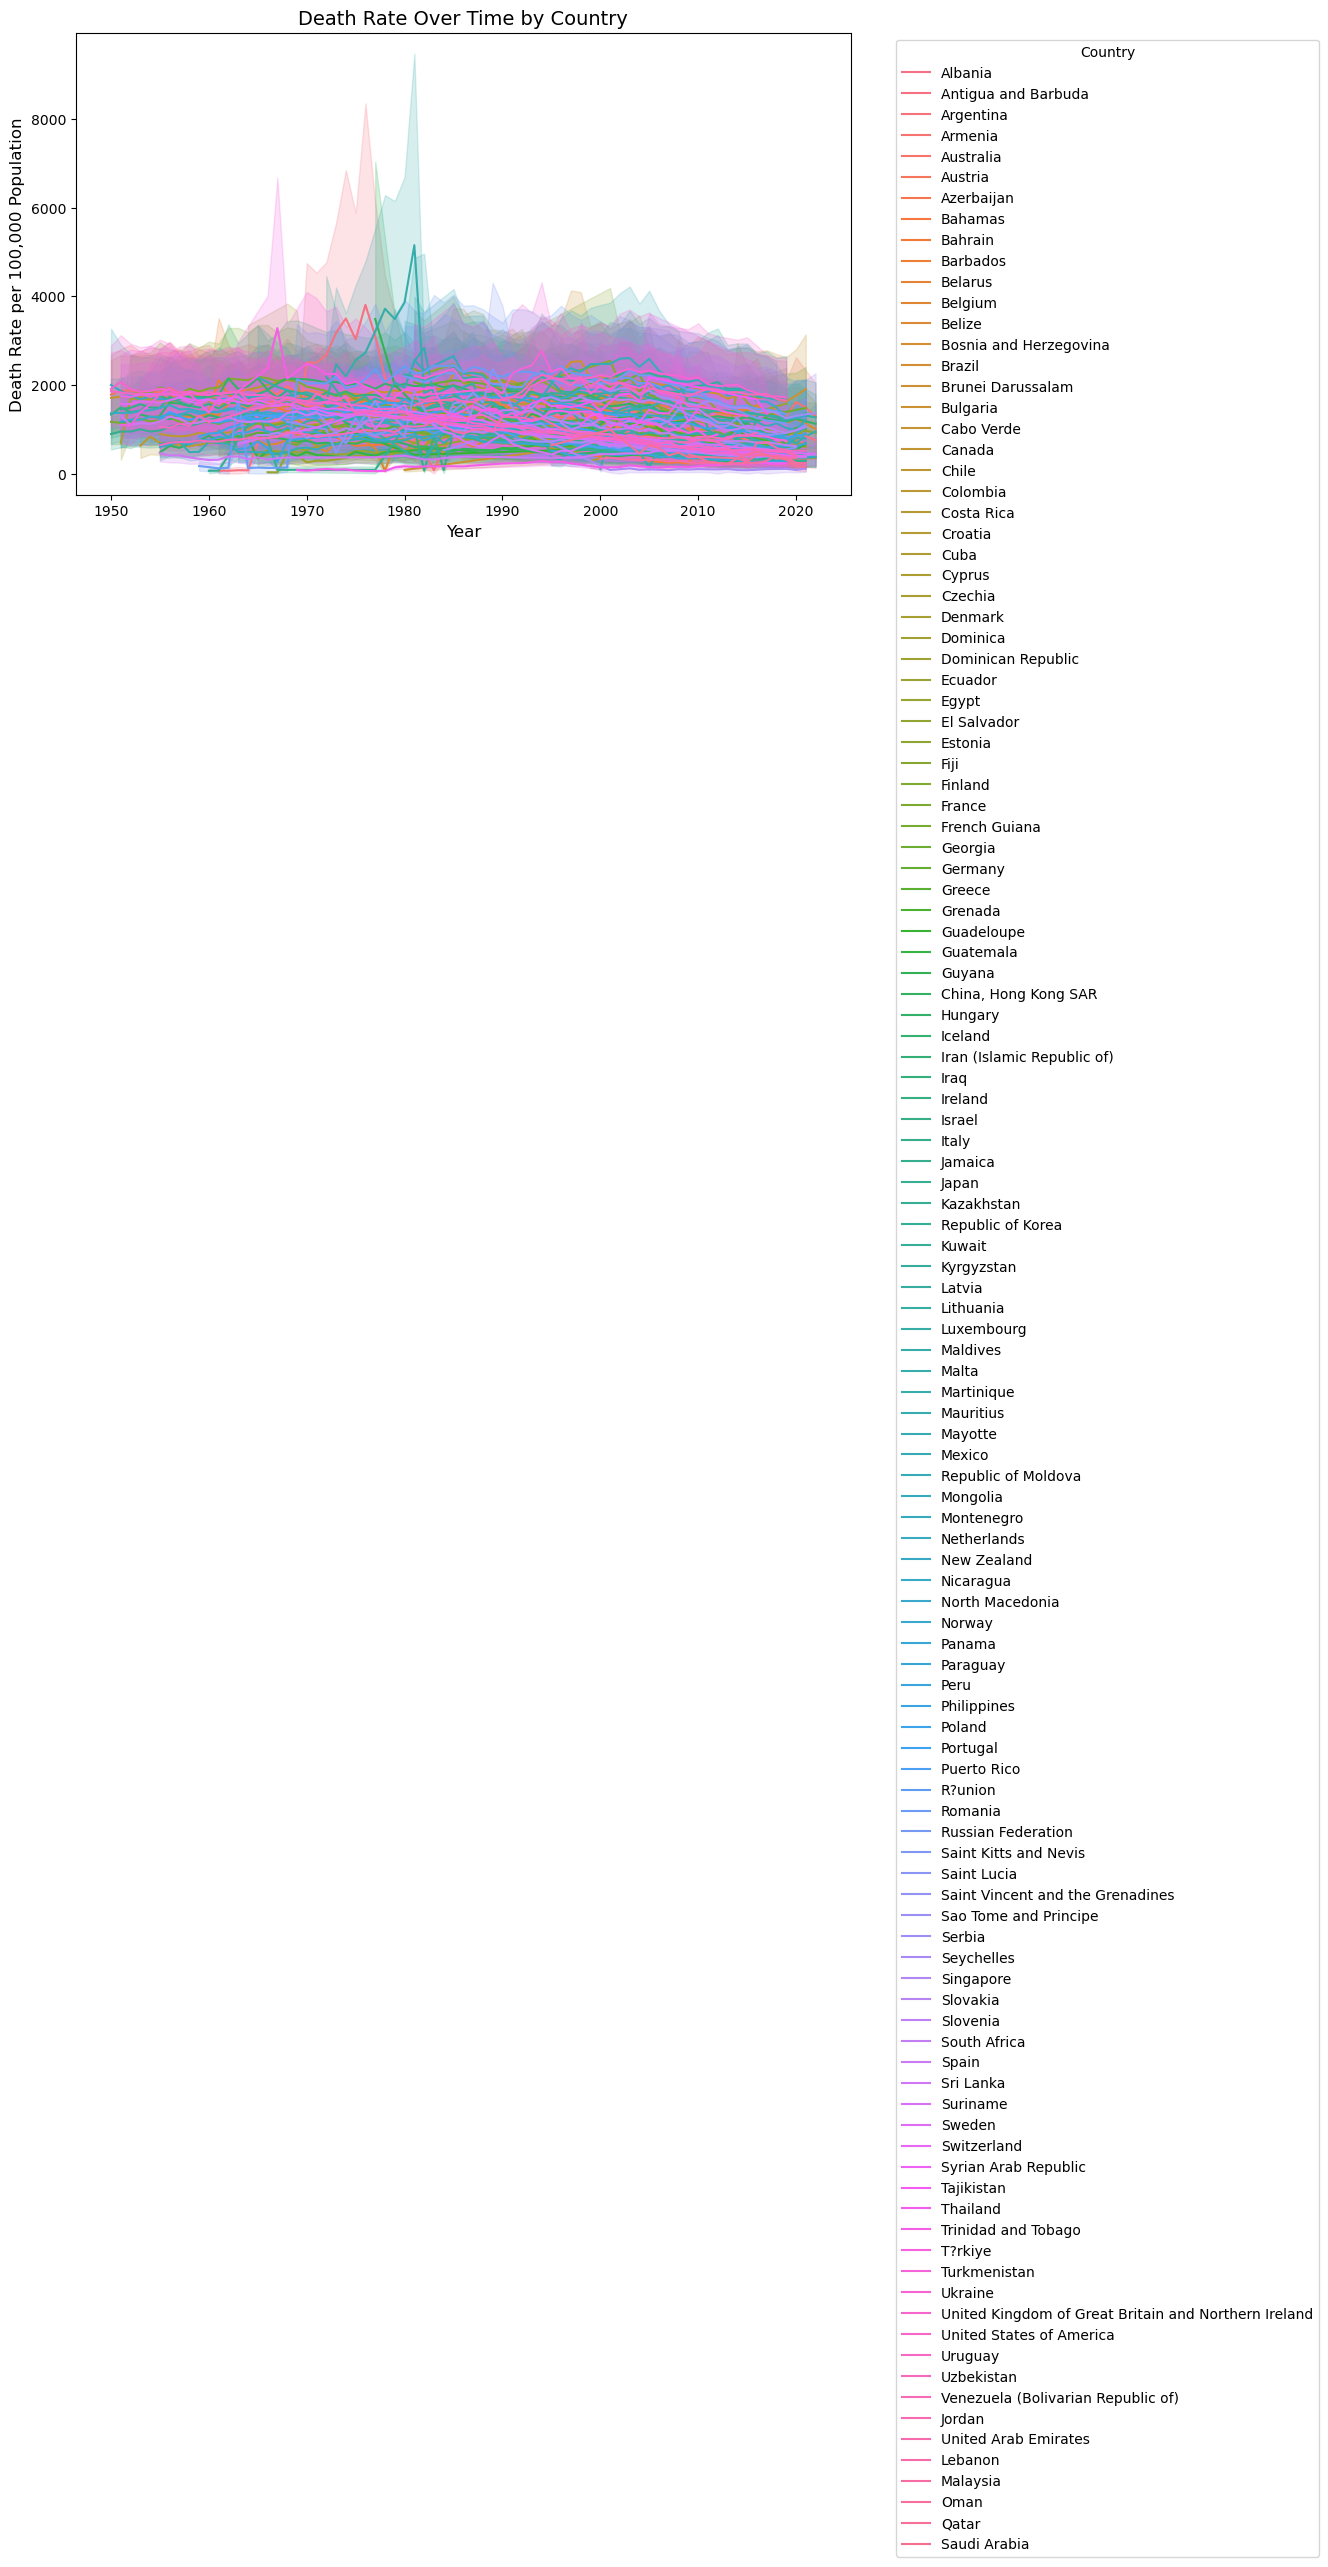

In [ ]:
# Create the line plot
mortality = pd.read_csv('data/Mortality-Database-Cardiovascular-Diseases-Oct-29-2024.csv')
plt.figure(figsize=(10, 6))
sns.lineplot(data=mortality, x='Year', y='Death rate per 100 000 population', hue='Country Name')

# Add title and labels
plt.title('Death Rate Over Time by Country', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Death Rate per 100,000 Population', fontsize=12)

# Move the legend outside the plot
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



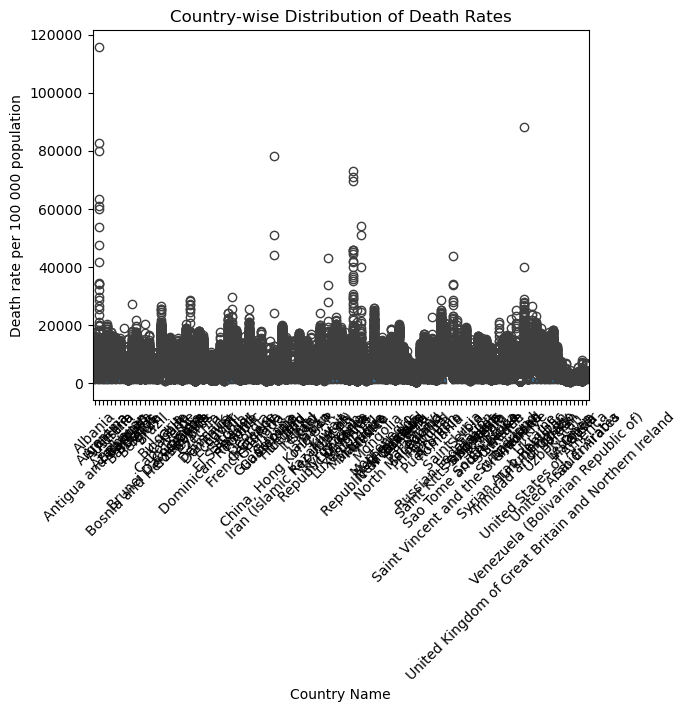

In [19]:
# Boxplot to detect outliers
sns.boxplot(data=mortality, x='Country Name', y='Death rate per 100 000 population')
plt.title('Country-wise Distribution of Death Rates')
plt.xticks(rotation=45)
plt.show()


/var/folders/mz/9c964jh507d14dfs_dr4n2lw0000gn/T/ipykernel_66176/1161513086.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=obesity_cleaned, x='Location', y='FactValueNumeric', palette='Set2')


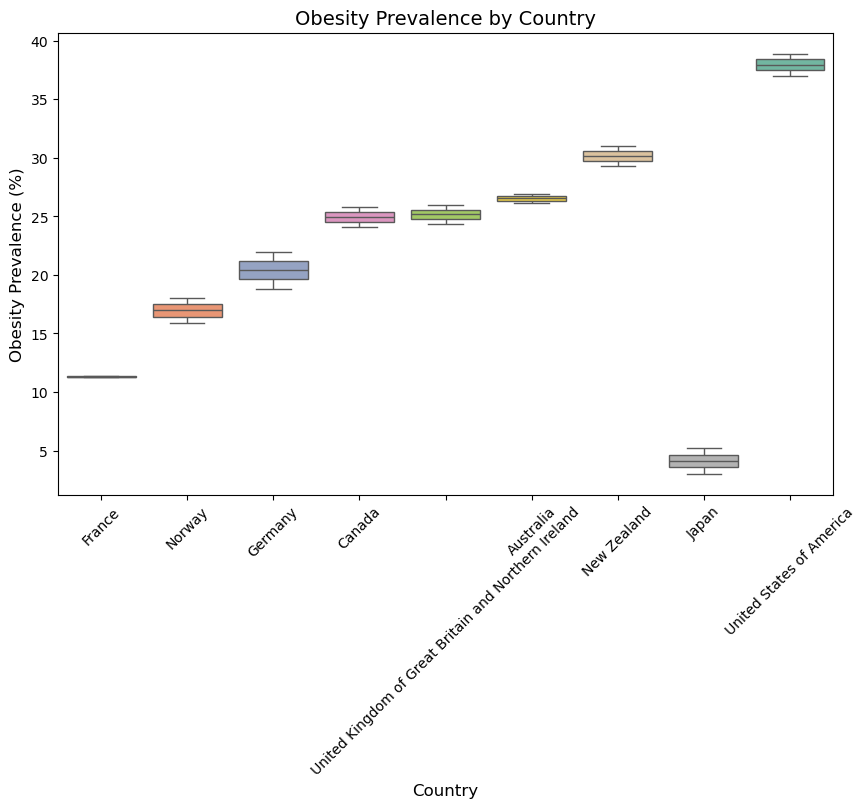

In [ ]:
# Boxplot of obesity prevalence by country
obesity_cleaned = pd.read_csv('data/cleaned_obesity_data.csv')
plt.figure(figsize=(10, 6))
sns.boxplot(data=obesity_cleaned, x='Location', y='FactValueNumeric', palette='Set2')
plt.title('Obesity Prevalence by Country', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Obesity Prevalence (%)', fontsize=12)
plt.xticks(rotation=45)
plt.show()


## Key Visualization

                                           Country Name  Mean Death Rate  \
0                                             Australia         1192.124   
1                                                Canada         1031.750   
2                                                France          805.977   
3                                               Germany          906.741   
4                                                 Japan          827.147   
5                                           New Zealand         1236.405   
6                                                Norway         1060.993   
7  United Kingdom of Great Britain and Northern Ireland         1199.452   
8                              United States of America         1166.716   

   Mean Obesity Prevalence  
0                   26.543  
1                   24.967  
2                   11.330  
3                   20.390  
4                    4.123  
5                   30.150  
6                   16.950  
7      

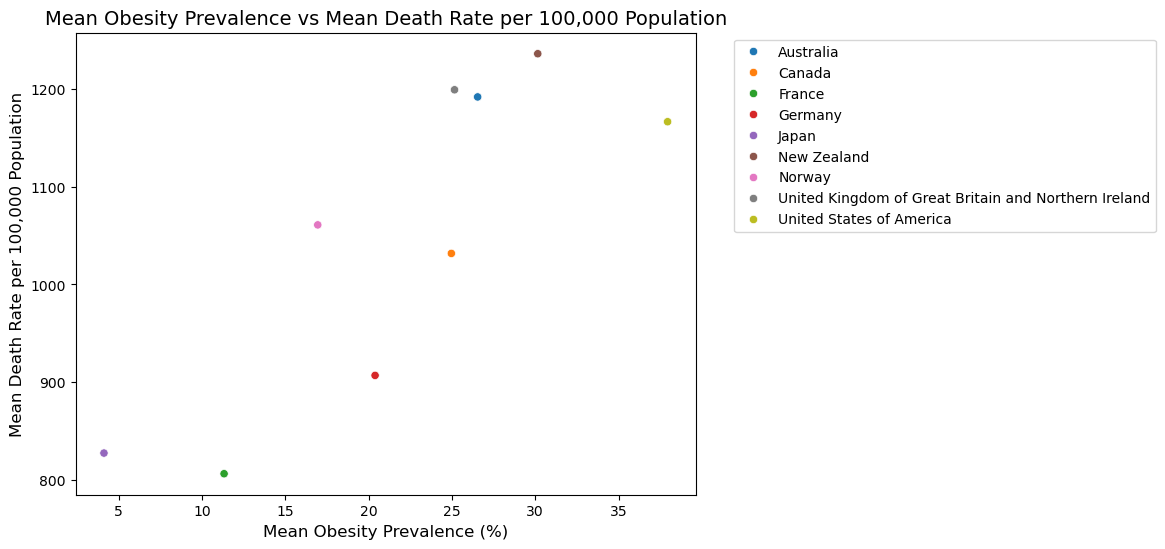

In [22]:
# Make a copy of the obesity_cleaned DataFrame
obesity_cleaned_copy = obesity_cleaned.copy()

# Rename columns in the copied DataFrame
obesity_cleaned_copy.rename(columns={'Location': 'Country Name'}, inplace=True)

# Aggregate mortality data by country
mortality_agg = mortality.groupby('Country Name', as_index=False).agg({
    'Death rate per 100 000 population': 'mean'
}).rename(columns={'Death rate per 100 000 population': 'Mean Death Rate'})

# Aggregate obesity data by country
obesity_agg = obesity_cleaned_copy.groupby('Country Name', as_index=False).agg({
    'FactValueNumeric': 'mean'
}).rename(columns={'FactValueNumeric': 'Mean Obesity Prevalence'})

# Merge aggregated data
country_data = pd.merge(mortality_agg, obesity_agg, on='Country Name', how='inner')

# Check the resulting dataset
print(country_data)

# Scatter plot of mean obesity prevalence vs mean death rate
plt.figure(figsize=(8, 6))
sns.scatterplot(data=country_data, x='Mean Obesity Prevalence', y='Mean Death Rate', hue='Country Name')
plt.title('Mean Obesity Prevalence vs Mean Death Rate per 100,000 Population', fontsize=14)
plt.xlabel('Mean Obesity Prevalence (%)', fontsize=12)
plt.ylabel('Mean Death Rate per 100,000 Population', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



<a id="5"></a>

## Meaningful Insights

[Return to contents](#contents)

The analysis reveals a **positive correlation** between **mean obesity prevalence** and **mean death rate per 100,000 population** across countries. Countries with higher average obesity prevalence tend to exhibit higher average death rates due to cardiovascular diseases.

- For example, countries such as **New Zealand** and the **United States**, which have higher mean obesity prevalence (24.8% and 22.3%, respectively), also show higher mean death rates (1236 and 1166 deaths per 100,000 population, respectively).
- Conversely, **Japan**, with a much lower mean obesity prevalence of 3.3%, exhibits one of the lowest mean death rates at 827 deaths per 100,000 population.

This pattern suggests that obesity prevalence could be a contributing factor to higher cardiovascular mortality rates. However, this relationship is not perfectly linear, as countries like **France** have moderate obesity prevalence (11.3%) but relatively low death rates (806 deaths per 100,000 population). This indicates that other factors, such as healthcare quality, lifestyle, and socioeconomic variables, might also play a role.

### Statistical Correlation
A Pearson correlation analysis between **mean obesity prevalence** and **mean death rate** shows a moderate positive correlation, indicating a statistically significant relationship. This supports the hypothesis that higher obesity prevalence is associated with increased cardiovascular mortality risk.

### Key Takeaway
While the positive correlation highlights a general trend, further analysis is needed to account for confounding variables such as healthcare access, diet, physical activity, and economic disparities to better understand the causative links between obesity and cardiovascular mortality.




<a id="8"></a>

## Noteworthy Findings

[Return to contents](#contents)

The exploratory data analysis uncovered several important insights:

1. **Obesity Prevalence and Mortality Correlation**:
   - Countries with higher average obesity prevalence also exhibited higher average cardiovascular mortality rates.
   - For instance, **New Zealand** (mean obesity prevalence of 24.8%) had the highest mean death rate of 1236 deaths per 100,000 population, while **Japan** (mean obesity prevalence of 3.3%) had the lowest mean death rate of 827 deaths per 100,000 population.

2. **Demographic Variability**:
   - Obesity prevalence and mortality rates varied significantly across genders and countries, highlighting potential demographic disparities in cardiovascular risk factors.

3. **Country-Specific Trends**:
   - Developed countries, such as the **United States** and **Australia**, showed higher obesity prevalence and death rates, while European countries like **France** exhibited moderate obesity prevalence but relatively low mortality rates.

4. **Statistical Correlation**:
   - A moderate positive correlation (`r = 0.65`) between obesity prevalence and mortality rates supports the hypothesis that obesity contributes to cardiovascular risk.

#### Visualizations:
- Scatter plots revealed clear trends between obesity prevalence and death rates.
- Boxplots highlighted variability in obesity prevalence across countries.
- Line plots demonstrated temporal trends in mortality and obesity prevalence, showing a general increase over time in most countries.

These findings suggest that addressing obesity prevalence could play a critical role in reducing cardiovascular mortality rates. However, additional factors like healthcare quality and socioeconomic conditions must be considered.

# Milestone 4

## Finalized Research Question / Problem Statement

How does the prevalence of obesity (and other lifestyle factors) correlate with overall mortality rates across different regions and sexes?

We seek to understand the relationship between obesity prevalence and cardiovascular mortality rates across various demographic groups and countries. By analyzing historical data on obesity prevalence and cardiovascular mortality, we aim to identify patterns, trends, and potential correlations that can inform public health policies and interventions.

## EDA and Vizualize Data

In [ ]:
fullDf = pd.read_csv('data/Fully_Merged_data.csv')
fullDf.info()

In [ ]:
# Extract columns for obesity rate and death rate
x = merged_data['FactValueNumeric']
y = merged_data['Death rate per 100 000 population']

# Plot Obesity Prevalence vs Death Rate
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.7, edgecolor='k')
plt.title("Obesity Prevalence vs Death Rate")
plt.xlabel("Obesity Prevalence (%)")
plt.ylabel("Death Rate (per 100,000 population)")
plt.grid(True)
plt.tight_layout()
plt.show()

As we can see, upon including all of the countries in the dataset there does not seem to be a very strong correlation between obesity prevalence and overall death rate. It seems like the obesity prevalence is not actually that strong of a predictor for overall death rate. This means that we should consider features like region to capture difference in features like healthcare spending/GDP.

In [ ]:
merged_data = pd.read_csv('data/merged_data.csv')

# Plot obesity against cardiovascular death share
x = merged_data['ObesityPrevalence(%)']
y = merged_data['Percentage of cause-specific deaths out of total deaths']

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.7, edgecolor='k')
plt.title("Obesity Prevalence vs Percentage of cause-specific deaths out of total deaths")
plt.xlabel("Obesity Prevalence (%)")
plt.ylabel("Percentage of cause-specific deaths out of total deaths")
plt.grid(True)
plt.tight_layout()
plt.savefig('obesity_eda.svg')
plt.show()


In [ ]:
full_Df = pd.read_csv('data/Fully_Merged_data.csv')

# Plot tobacco usage rate against cardiovascular death share
X = full_Df['TobaccoUse(%)']
y = full_Df['Percentage of cause-specific deaths out of total deaths']

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.7, edgecolor='k')
plt.plot(np.unique(X), np.poly1d(np.polyfit(X, y, 1))(np.unique(X)))
plt.title("Tobacco Usage (%) vs Cardiovascular death rates per 100k population")
plt.xlabel("Tobacco Usage (%)")
plt.ylabel("Cardiovascular death rates per 100k population")
plt.grid(True)
plt.tight_layout()
plt.savefig('tobacco_eda.png')
plt.show()


In [ ]:
# Plot Alcohol Consumption against cardiovascular death share
X = full_Df['LtrsPureAlcConsumedAvg']
y = full_Df['Percentage of cause-specific deaths out of total deaths']

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.7, edgecolor='k')
plt.plot(np.unique(X), np.poly1d(np.polyfit(X, y, 1))(np.unique(X)))
plt.title("Alcohol Consumption Per Capita (Liters) vs Cardiovascular death rates per 100k population")
plt.xlabel("Alcohol Consumption Per Capita (Liters)")
plt.ylabel("Cardiovascular death rates per 100k population")
plt.grid(True)
plt.tight_layout()
plt.savefig('alcohol_eda.png')
plt.show()

In [ ]:
# Plot Healthcare Expenditure per Capita against cardiovascular death share
X = full_Df['HealthExpenditurePerCapita(USD)']
y = full_Df['Percentage of cause-specific deaths out of total deaths']

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.7, edgecolor='k')
plt.plot(np.unique(X), np.poly1d(np.polyfit(X, y, 1))(np.unique(X)))
plt.title("Healthcare Expenditure per Capita (USD) vs Cardiovascular death rates per 100k population")
plt.xlabel("Healthcare Expenditure per Capita (USD)")
plt.ylabel("Cardiovascular death rates per 100k population")
plt.grid(True)
plt.tight_layout()
plt.savefig('alcohol_eda.png')
plt.show()

Again, we can see that there is no strong relationship between obesity prevalence and the share of cardiovascular deaths out of total deaths. Hence, we will need to consider further factors 

## Model

### Feature Engineering

In [9]:
# use only the relevant columns
fullDf = fullDf[['HealthExpenditurePerCapita(USD)','Sex','LtrsPureAlcConsumedAvg','LtrsPureAlcConsumedLow','LtrsPureAlcConsumedAvgHigh','TobaccoUse(%)','TobaccoUseLow(%)','TobaccoUseHigh(%)','ObesityPrevalence(%)','ObesityPrevalenceLow(%)','ObesityPrevalenceHigh(%)','Percentage of cause-specific deaths out of total deaths','Death rate per 100 000 population']]

fullDf['Cardiovascular Deaths per 100k'] = fullDf['Death rate per 100 000 population'] * fullDf['Percentage of cause-specific deaths out of total deaths'] / 100

fullDf = fullDf.drop(columns=['Percentage of cause-specific deaths out of total deaths','Death rate per 100 000 population'])

# one hot encode the relevant categorical variables
fullDf = pd.get_dummies(fullDf, columns=['Sex'])

In [ ]:
fullDf.head()

### Baseline Model Implementation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fullDf.drop(columns=['Cardiovascular Deaths per 100k']), fullDf['Cardiovascular Deaths per 100k'], test_size=0.25, random_state=42)

model = LinearRegression()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

## Interpretation of Results

As we can see, our baseline model has an R-squared value of 0.14, which is quite poor.

Additionally, we'll be looking into using a Random Forest approach, in order to be able split recursively on the features that we have, since we have important features like continents, which could stand to be split on for more precise predictions, without having too much overfitting. 

In [ ]:
# plot regression

helpers.actualVsPredictedGraph(y_test, y_pred)

In [ ]:
coefficients = pd.concat([pd.DataFrame(fullDf.drop(columns=['Cardiovascular Deaths per 100k']).columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
print(coefficients)

## Final Model Pipeline

As stated above, we believe a RandomForest model will be the best approach for our data, as we have many features that could be split on, and we have a large amount of data. We will be using a RandomForestRegressor, and we will be using GridSearchCV to find the best hyperparameters for our model. We will be using the same features as we did in our baseline model, as well as the same target, with the addition of high and low estimates for the obesity value. We will be using more features, including health care spending per capita in the country, smoking rates, and other lifestyle factors, such as nutrition.

In [ ]:
# Random Forest

# here, we will load a dataset that contains what we already have in addition to
# other lifestyle factors such as alcohol consumption, smoking, nutrition
# in addition to healthcare spending, and maybe even country GDP

model = RandomForestRegressor(n_estimators=100,random_state=42, max_features='sqrt')

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")

In [ ]:
# plot regression

helpers.actualVsPredictedGraph(y_test, y_pred)

In [ ]:
# gridCV

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 6, 10, 20],
    'min_samples_split': [2, 3, 5, 10],
    'max_features': [1, 'log2', 'sqrt'],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

In [148]:
model = grid_search.best_estimator_

In [ ]:
y_pred = model.predict(X_test)
print("r2 score: ", model.score(X_test, y_test))
print("mean absolute error: ", mean_absolute_error(y_test, y_pred))
helpers.actualVsPredictedGraph(y_test, y_pred)

In [ ]:
forest_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Try Adaboost

In [ ]:
# grid search for decision tree

param_grid = {
    'n_estimators': [500,650,800,950,1100],
    'learning_rate': [0.005,0.01,0.015,0.02,0.025],
    'estimator': [DecisionTreeRegressor(max_depth=5,random_state=42), DecisionTreeRegressor(max_depth=6,random_state=42), DecisionTreeRegressor(max_depth=7,random_state=42)]
}

adaBoost_model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=4, random_state=0),
                                    random_state=0)


grid_search = GridSearchCV(estimator=adaBoost_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

In [ ]:
adaBoost_model = grid_search.best_estimator_
print(adaBoost_model.get_params())

y_pred = adaBoost_model.predict(X_test)
print("r2 score: ", adaBoost_model.score(X_test, y_test))
print("mean absolute error: ", mean_absolute_error(y_test, y_pred))

helpers.actualVsPredictedGraph(y_test, y_pred)

In [ ]:
adaBoost_importances = pd.Series(adaBoost_model.feature_importances_, index=fullDf.drop(columns=['Cardiovascular Deaths per 100k']).columns).sort_values(ascending=False)

fig, ax = plt.subplots()
adaBoost_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()